# Welcome to ML-MotEx

Github: https://github.com/AndySAnker/ML-MotEx/StackingFaults

Paper: Characterisation of intergrowth in metal oxide materials using structure-mining: the case of γ-MnO2

Questions: andy@chem.ku.dk & nima@chem.ku.dk

Use this script to use ML-MotEx to extract a stacking fault distribution from a dataset. This script does both handle fits made on Pair Distribution Function (PDF) data and Powder X-ray Diffraction (PXRD) data.

The script first import packages and defines functions.

Section 1: We import the stacking fault sequences and their Rwp values

Section 2: We train a gradient boosted decision tree to predict the Rwp value from the stacking fault sequence 

Section 3: We plot the importance of the layers and why they are important. Do the model like specific layers?

Section 4: We extract the information in two lists, good atoms/bad layers. We calculate the stacking fault distribution.

# Import modules and set seed parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, random, shap, sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
random.seed(14)
np.random.seed(14)

# Define functions

In [2]:
def Train_XGBoost_XY(X_train, y_train, learning_rate, max_depth, n_estimators, n_jobs, gamma, min_child_weight, base_score, seed, xgb_model=None):
    start_time = time.time()
    model = xgb.XGBRegressor(learning_rate = learning_rate, max_depth=max_depth, n_estimators=n_estimators, n_jobs=n_jobs, gamma=gamma, min_child_weight=min_child_weight, base_score=base_score, random_state=seed)
    model.fit(X_train, y_train, xgb_model=xgb_model)
    print("Total execution time: %.3fs"%(time.time()-start_time))
    print ("Training Succeeded")
    return model
    
def Validate_XGBoost(model, X_val, y_val):
    print ("Giving an estimate of the accuracy of the model")
    y_pred_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print("RMSE: %f" % (rmse))
    return rmse

def shap_essential_figure(model, X_train):
    plt.clf()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) #to explain every prediction
    shap.summary_plot(shap_values, X_train, feature_names=names[2:], max_display=20, show=False) # to plot these explanations
    return explainer, shap_values


# 1 Import data ready for machine learning

In [3]:
fileName = "Training_Data/info_Intergrowth_ML_XRD_Diamond2h.txt"
Layers = 250

names = ['index', 'Rwp', 'Pb', 'Pr', 'percent_B', 'percent_R']+['Block_sequence'+str(i) for i in range(1, Layers+1)]+['Intergrowth_sequence'+str(i) for i in range(1, Layers+1)]
data = pd.read_csv(fileName, names=names, delimiter=" ") # Read data file
data = data.drop(data.columns[-1],axis=1) # Drop the last column with NANS
data = data.drop(data.columns[0],axis=1) # Drop index
data = data.replace(['P','R'], [0, 1]) # 0 is P, 1 is R

y = data['Rwp'] # Rwp is labels
X = data.drop(data.columns[0], axis=1) # Drop labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) # Split the data into training and validation set


### Check that data is imported correct

Check 1: Is the number of training data 4 times larger than validation data? 

Check 2: Print y_train and make sure it is the Rwp values of the fits.

Check 3: Print X_train and make sure that the first 5 entries are index, Pb, Pr, percent_B, percent_R. The next should be Block_sequence0, Block_sequence1, etc... the last should be Intergrowth_sequence0, Intergrowth_sequence1, etc...

In [4]:
# Check 1
print ("Number of Training Data:", len(X_train))
print ("Number of Validation Data:", len(X_val))

Number of Training Data: 3960
Number of Validation Data: 990


In [12]:
# Check 2
print (y_train.head())
print ()
print ("Stastical information about the Rwp distribution")
print (y_train.describe())

634     15.24904
2571    13.62155
3372    13.99128
1463    14.55927
1486    18.56308
Name: Rwp, dtype: float64

Stastical information about the Rwp distribution
count    3960.000000
mean       16.058357
std         2.434773
min        12.214000
25%        14.086435
50%        15.619260
75%        17.753375
max        26.120980
Name: Rwp, dtype: float64


In [6]:
# Check 3
X_train.head()

,Pb,Pr,percent_B,percent_R,Block_sequence1,Block_sequence2,Block_sequence3,Block_sequence4,Block_sequence5,Block_sequence6,...,Intergrowth_sequence240,Intergrowth_sequence241,Intergrowth_sequence242,Intergrowth_sequence243,Intergrowth_sequence244,Intergrowth_sequence245,Intergrowth_sequence246,Intergrowth_sequence247,Intergrowth_sequence248,Intergrowth_sequence249
634,0.13,0.84,0.155340,0.844660,1,2,2,1,2,1,...,1,1,1,0,1,1,1,1,1,0
2571,0.52,0.71,0.376623,0.623377,1,1,1,1,2,1,...,0,1,1,1,1,1,0,0,0,0
3372,0.68,0.72,0.466667,0.533333,1,1,2,2,2,2,...,1,1,1,1,1,1,1,1,1,0
1463,0.30,0.63,0.345794,0.654206,1,2,1,2,1,1,...,0,1,0,1,0,1,1,0,0,1
1486,0.30,0.86,0.166667,0.833333,1,1,2,1,1,2,...,1,1,1,1,1,1,1,1,1,1


# 2 Train the gradient boosted decision tree algorithm

The parameters  can be changed in order to get the lowest possible root mean squared error (RMSE). Normally only learning rate and max_depth is changed. Max depth can only be changed as integers.

In [20]:
lr = 0.25 # 0.1 is default - Boosting learning rate
max_depth = 3 # 3 is default - Maximum tree depth for base learners.
n_estimators = 100 # 100 is default - Number of trees to fit. 
n_jobs = 1 # 1 is default - Number of parallel threads used to run xgboost.
gamma = 0 # 0 is default - Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight = 1 # 1 is default - Minimum sum of instance weight(hessian) needed in a child.
base_score = 0.5 # 0.5 is default - The initial prediction score of all instances, global bias.
random_state = 0 # 0 is default - seeding

# Set up a ML algorithm based on the loaded permutations
model = Train_XGBoost_XY(X_train, y_train, learning_rate=lr, max_depth=max_depth, n_estimators=n_estimators, n_jobs=n_jobs, gamma=gamma, min_child_weight=min_child_weight, base_score=base_score, seed=random_state)
Validate_XGBoost(model, X_val, y_val)
model.save_model("ML_algorithms/Stacking_faults_manual_model.dat")


Total execution time: 16.506s
Training Succeeded
Giving an estimate of the accuracy of the model
RMSE: 0.909217


# 3 Plot how important the features (atoms) are in the structure and why they are important

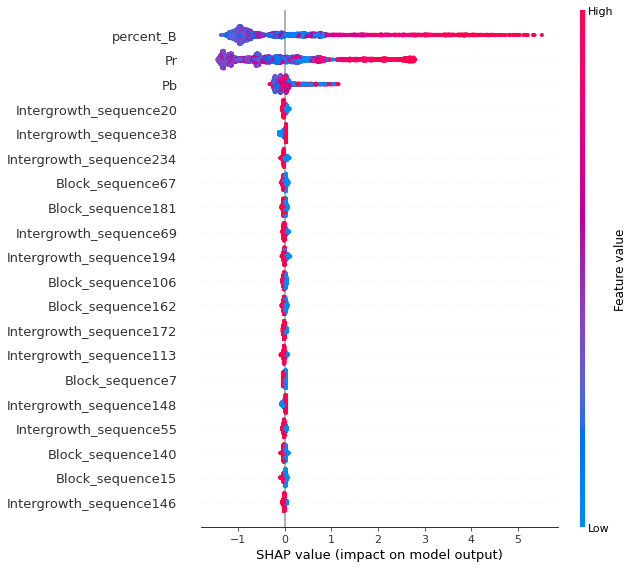

In [21]:
explainer, shap_values = shap_essential_figure(model, X_train.values)

# 4 Block Sequence

Best Sequences: (array([  1,   3,   6,   7,   8,  10,  11,  13,  14,  17,  19,  20,  23,
        26,  28,  33,  36,  38,  40,  41,  44,  48,  59,  61,  64,  66,
        67,  71,  72,  76,  80,  81,  83,  89,  96,  99, 102, 103, 104,
       105, 109, 110, 116, 117, 122, 123, 124, 125, 127, 129, 139, 142,
       144, 146, 148, 153, 161, 162, 163, 167, 169, 173, 175, 177, 179,
       180, 184, 188, 190, 192, 195, 198, 199, 203, 207, 208, 210, 213,
       216, 217, 220, 227, 228, 230, 233, 234, 236, 239, 240]),)
Worst Sequences: (array([  4,  31,  46,  75,  77,  95, 101, 108, 112, 114, 130, 141, 165,
       171, 176, 181, 185, 189, 204, 205, 232, 243, 248, 249]),)


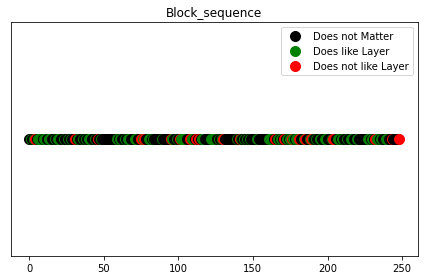

In [22]:
# Calculate the layer contribution value for each layer
Block_sequence_list = []
for i in range(4, 4+1*Layers):
    keep_atoms = np.sum((shap_values[np.where(X_train.values[:,i] == 2),i]))
    remove_atoms = np.sum((shap_values[np.where(X_train.values[:,i] == 1),i]))
    Block_sequence_list.append(keep_atoms - remove_atoms)

lower_percentile = 0
print ("Best Sequences:", np.where((np.array(Block_sequence_list) < lower_percentile) & (np.array(Block_sequence_list) < 0)))
print ("Worst Sequences:", np.where((np.array(Block_sequence_list) > lower_percentile) & (np.array(Block_sequence_list) > 0)))

count_b = 0
count_g = 0
count_r = 0
for i in range(Layers-1):
    if Block_sequence_list[i] == 0:
        color = "k"
        label = "Does not Matter"
        plt.plot(i, 0, "o", color=color, markersize=10, label=label if count_b == 0 else "_nolegend_")
        count_b += 1
    elif Block_sequence_list[i] < lower_percentile:
        color = "g"
        label = "Does like Layer"
        plt.plot(i, 0, "o", color=color, markersize=10, label=label if count_g == 0 else "_nolegend_")
        count_g += 1
    elif Block_sequence_list[i] > lower_percentile:
        color = "r"
        label = "Does not like Layer"
        plt.plot(i, 0, "o", color=color, markersize=10, label=label if count_r == 0 else "_nolegend_")
        count_r += 1

# Plot the results
plt.yticks([], [])
plt.legend()
plt.title("Block_sequence")
plt.tight_layout()
plt.show()


# Intergrowth sequence

Best Sequences: (array([ 10,  12,  19,  24,  31,  33,  34,  39,  42,  46,  54,  59,  60,
        61,  68,  70,  72,  73,  78,  80,  82,  83,  86,  87,  90,  93,
        94,  98,  99, 101, 104, 105, 106, 107, 110, 112, 113, 115, 117,
       118, 119, 120, 121, 123, 126, 127, 130, 132, 133, 134, 137, 138,
       139, 140, 141, 143, 145, 152, 158, 160, 162, 163, 166, 168, 171,
       175, 178, 180, 182, 183, 186, 188, 192, 193, 198, 199, 200, 201,
       204, 206, 209, 211, 216, 217, 221, 222, 225, 226, 229, 230, 231,
       233, 234, 237, 239, 242, 243, 244, 246]),)
Worst Sequences: (array([  1,   2,   4,   6,   7,   9,  11,  20,  21,  23,  28,  32,  36,
        37,  40,  41,  43,  51,  53,  58,  64,  65,  66,  79,  81,  84,
        85,  88,  92, 100, 108, 116, 122, 124, 125, 128, 131, 146, 147,
       153, 154, 155, 167, 169, 172, 174, 176, 184, 197, 202, 203, 207,
       210, 212, 214, 220, 224, 228, 240]),)


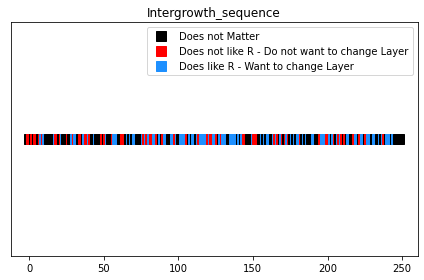

In [23]:
# Calculate the layer contribution value for each layer
Intergrowth_sequence_list = []
for i in range(4+Layers, 4+2*Layers-1):
    keep_atoms = np.sum((shap_values[np.where(X_train.values[:,i] == 1),i]))
    remove_atoms = np.sum((shap_values[np.where(X_train.values[:,i] == 0),i]))
    Intergrowth_sequence_list.append(keep_atoms - remove_atoms)

lower_percentile = 0
print ("Best Sequences:", np.where((np.array(Intergrowth_sequence_list) < lower_percentile) & (np.array(Intergrowth_sequence_list) < 0)))
print ("Worst Sequences:", np.where((np.array(Intergrowth_sequence_list) > lower_percentile) & (np.array(Intergrowth_sequence_list) > 0)))

count_b = 0
count_g = 0
count_r = 0
for i in range(Layers-1):
    if Intergrowth_sequence_list[i] == 0:
        color = "k"
        label = "Does not Matter"
        plt.plot(i, 0, "o", color=color, marker="s", markersize=10, label=label if count_b == 0 else "_nolegend_")
        count_b += 1
    elif Intergrowth_sequence_list[i] < lower_percentile:
        color = "g"
        label = "Does like R - Want to change Layer"
        plt.plot(i, 0, "o", color='dodgerblue', marker="s", markersize=10, label=label if count_g == 0 else "_nolegend_")
        count_g += 1
    elif Intergrowth_sequence_list[i] > lower_percentile:
        color = "r"
        label = "Does not like R - Do not want to change Layer"
        plt.plot(i, 0, "o", color=color, marker="s", markersize=10, label=label if count_r == 0 else "_nolegend_")
        count_r += 1
        
# Plot the results
plt.yticks([], [])
plt.legend()
plt.title("Intergrowth_sequence")
plt.tight_layout()
plt.show()


# Calculate the stacking fault distributions

[1, 2, 4, 6, 7, 9, 11, 20, 21, 23, 28, 32, 36, 37, 40, 41, 43, 51, 53, 58, 64, 65, 66, 79, 81, 84, 85, 88, 92, 100, 108, 116, 122, 124, 125, 128, 131, 146, 147, 153, 154, 155, 167, 169, 172, 174, 176, 184, 197, 202, 203, 207, 210, 212, 214, 220, 224, 228, 240]
[0.   0.44 0.88 1.32 1.76 2.2  2.64 3.08 3.52 3.96 4.4  4.84 5.28 5.72
 6.16 6.6  7.04 7.48 7.92 8.36]
[0.         0.         0.47798742 0.28301887 0.10062893 0.06289308
 0.0754717  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


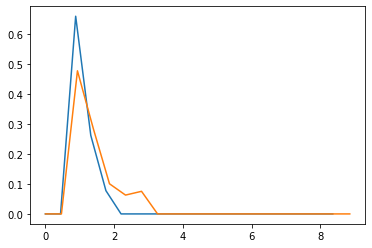

In [24]:
Pyr_blocks = []
Ram_blocks = []
for i in range(len(Intergrowth_sequence_list)):
    if Intergrowth_sequence_list[i]>lower_percentile:
        Pyr_blocks.append(i)
    if Intergrowth_sequence_list[i]<lower_percentile:
        Ram_blocks.append(i)
print(Pyr_blocks)
list_DSD_pyr = np.zeros(20)        #plot number of domains of a given size
list_DSD_pyr_freq = np.zeros(20)   #plot frequence of domains with a given size
list_DSD_pyr_vol = np.zeros(20)    #plot frequence of domain related to size
list_DSD_ram = np.zeros(20)
list_DSD_ram_freq = np.zeros(20)
list_DSD_ram_vol = np.zeros(20)
block_arr = np.linspace(0, 19, 20)
x_array_pyr = np.array([i*0.44 for i in range(0, 20)]) 
x_array_ram = np.array([i*0.466 for i in range(0, 20)]) 

i=0
block = 1
freq_Pyr=0
vol_Pyr=0
while i<len(Pyr_blocks)-1:
    if Pyr_blocks[i+1]==Pyr_blocks[i]+1:
        block +=1
    if Pyr_blocks[i+1]!=Pyr_blocks[i]+1:
        list_DSD_pyr[block+1]+=1
        block = 1
    i+=1
freq_Pyr = np.sum(list_DSD_pyr)
for j in range(len(list_DSD_pyr)):
    list_DSD_pyr_freq[j]=list_DSD_pyr[j]/freq_Pyr
    vol_Pyr+=list_DSD_pyr[j]*x_array_pyr[j]
for k in range(len(list_DSD_pyr)):
    list_DSD_pyr_vol[k]=list_DSD_pyr[k]*x_array_pyr[k]/vol_Pyr
    
sigma_count = np.ones(20)*1.5
sigma_count += np.sqrt(list_DSD_pyr)
sigma_vol = sigma_count*x_array_pyr/vol_Pyr

    

i=0
block = 1 
freq_Ram = 0
vol_Ram=0
while i<len(Ram_blocks)-1:
    if Ram_blocks[i+1]==Ram_blocks[i]+1:
        block +=1
    if Ram_blocks[i+1]!=Ram_blocks[i]+1:
        list_DSD_ram[block+1]+=1
        block = 1
    i+=1
freq_Ram = np.sum(list_DSD_ram)
for j in range(len(list_DSD_ram)):
    list_DSD_ram_freq[j]=list_DSD_ram[j]/freq_Pyr
    vol_Ram+=list_DSD_ram[j]*x_array_ram[j]
for k in range(len(list_DSD_ram)):
    list_DSD_ram_vol[k]=list_DSD_ram[k]*x_array_ram[k]/vol_Ram

print(x_array_pyr)
print(list_DSD_ram_vol)

plt.plot(x_array_pyr, list_DSD_pyr_vol)
plt.plot(x_array_ram, list_DSD_ram_vol)
plt.show()